In [1]:
import os
import warnings

import numpy as np 

from scipy.stats import chisquare

from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.stats import mad_std, gaussian_sigma_to_fwhm
from astropy.table import Table
from astropy.modeling import models, fitting, functional_models, Parameter
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.utils.exceptions import AstropyWarning
from astropy import units as u

from astropy.stats import gaussian_fwhm_to_sigma

from photutils import DAOStarFinder
from photutils import aperture_photometry, CircularAperture

In [2]:
from lcbg.utils import cutout, measure_fwhm
from lcbg.fitting import fit_gaussian2d, fit_sersic2d, plot_fit

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
plt.rcParams['figure.figsize'] = [12, 12]

# Local Paths (NB Inputs)

In [4]:
input_data_path = "https://archive.stsci.edu/pub/hlsp/frontier/abell370/images/hst/v1.0-epoch2/hlsp_frontier_hst_wfc3-30mas_abell370_f105w_v1.0-epoch2_drz.fits"
input_data_path = "https://archive.stsci.edu/pub/hlsp/frontier/abell370/images/hst/v1.0-epoch2/hlsp_frontier_hst_wfc3-30mas-bkgdcor_abell370_f105w_v1.0-epoch2_drz.fits"
# input_data_path = "https://archive.stsci.edu/pub/hlsp/frontier/abell370/images/hst/v1.0-epoch2/hlsp_frontier_hst_acs-30mas-selfcal_abell370-hffpar_f435w_v1.0-epoch2_drz.fits"
output_path = "{}_catalog.csv".format(os.path.splitext(os.path.basename(input_data_path))[0])

print("Output: ", output_path)

Output:  hlsp_frontier_hst_wfc3-30mas-bkgdcor_abell370_f105w_v1.0-epoch2_drz_catalog.csv


# Load Data

In [5]:
hdul = fits.open(input_data_path)
hdu = hdul[0]

In [6]:
data = hdu.data
header = hdu.header
wcs = WCS(header)

In [7]:
#plt.imshow(data, vmin=0, vmax=2.9534784e-05*90)

# Estimate Mean Noise

0.000312165

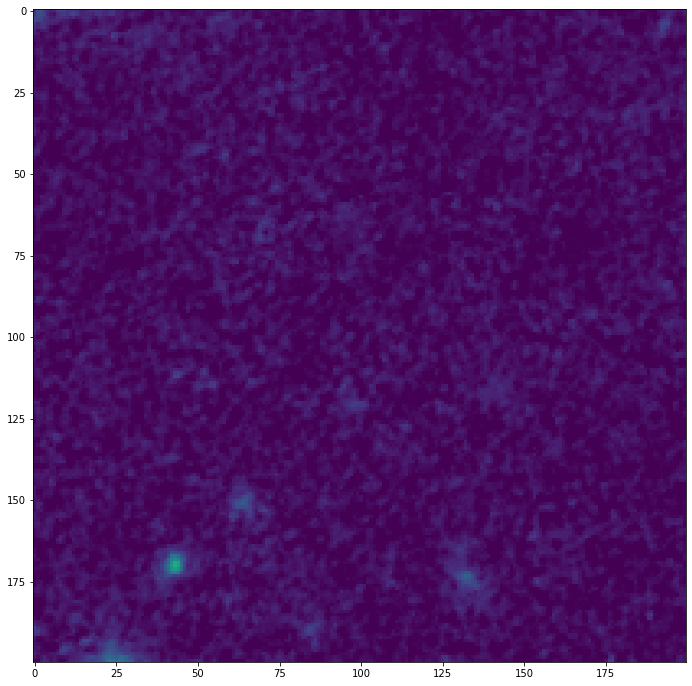

In [8]:
subsection = cutout(data, 4444, 10150, 200)
plt.imshow(subsection, vmin=0, vmax=2.9534784e-05*350)
subsection.mean()

In [9]:
mean_noise = subsection.mean()
mean_noise

0.000312165

# Aperture Photometry

### Select Image

In [10]:
cx, cy = wcs.world_to_pixel_values(header["RA_TARG"], header["DEC_TARG"])
#image = cutout(data, int(cx), int(cy), 6000)
image = cutout(data, int(cx), int(cy), 4000)

#image = cutout(data, 2072, 8309, 1000)
#image = cutout(data, 3791, 7332, 2000)
#image = data[1000:-1000,1000:-1000]

#image -= mean_noise
#mean_noise = image.mean()

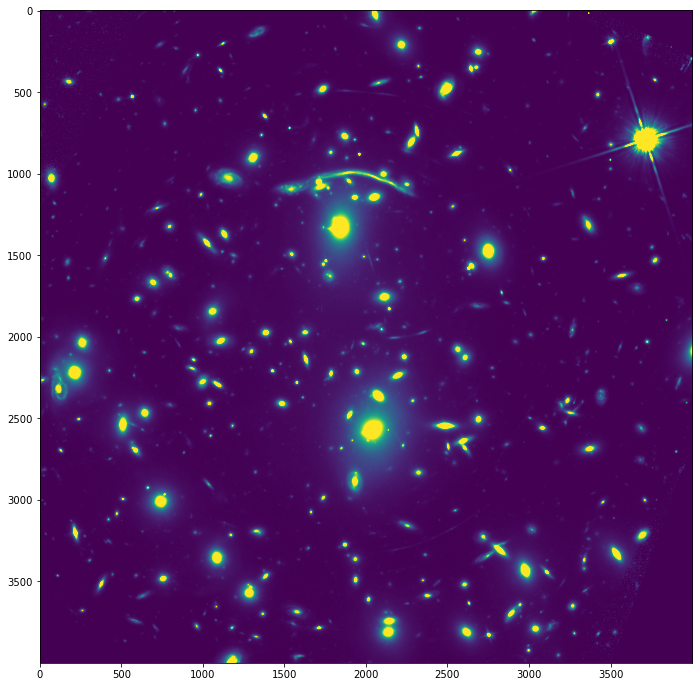

In [11]:
plt.imshow(image, vmin=0, vmax=mean_noise*300)

### Make Segments

In [12]:
from photutils import detect_threshold
from photutils import deblend_sources
from photutils import source_properties
from photutils import detect_sources
from photutils import source_properties, EllipticalAperture

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

In [13]:
def plot_segments(segm, image=None, vmin=None, vmax=None):
    cmap = segm.make_cmap(random_state=np.random.randint(1000000))
    alpha = 1
    if image is not None:
        alpha = 0.5
        plt.imshow(image, vmin=vmin, vmax=vmax, cmap="gist_gray")

    plt.imshow(segm, cmap=cmap, alpha=alpha)

    plt.title('Segmentation Image')
    
def plot_segment_residual(segm, image, vmin=None, vmax=None):
    temp = image.copy()
    temp[np.where(segm.data != 0)] = 0.0
    plt.imshow(temp, vmin=0, vmax=mean_noise*50)

In [14]:
def make_kernel(fwhm, kernel_size):
    sigma = fwhm * gaussian_fwhm_to_sigma  
    kernel = Gaussian2DKernel(sigma, x_size=kernel_size, y_size=kernel_size)
    kernel.normalize()
    return kernel

def make_segments(image, npixels=None, nsigma=3., fwhm=8., kernel_size=4):

    if npixels is None:
        npixels = fwhm**2 
    
    kernel = make_kernel(fwhm, kernel_size) if kernel_size else None 
    
    # Make detection threshold
    threshold = detect_threshold(image, nsigma=nsigma)
    
    return detect_sources(image, threshold, npixels=npixels, filter_kernel=kernel,)  
    
def deblend_segments(image, segm, npixels=None, nsigma=3., fwhm=8., kernel_size=4, nlevels=30, contrast=1/1000):
    
    if npixels is None:
        npixels = fwhm**2 
        
    kernel = make_kernel(fwhm, kernel_size) if kernel_size else None 

    segm_deblend = deblend_sources(image, segm, 
                                   npixels=npixels, filter_kernel=kernel,
                                   nlevels=nlevels, contrast=contrast)

    return segm_deblend 

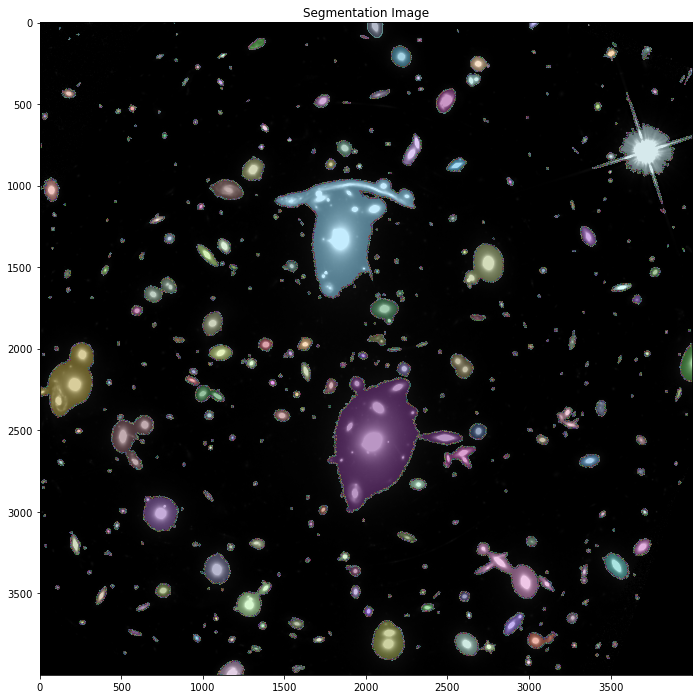

In [15]:
segm = make_segments(image, nsigma=8)
plot_segments(segm, image, vmin=0, vmax=mean_noise*300)

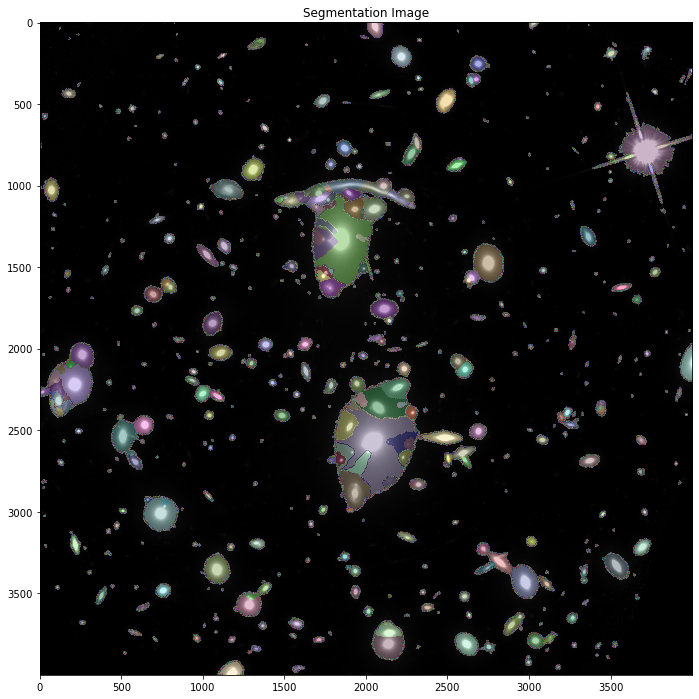

In [26]:
segm_deblend = deblend_segments(image, segm)
plot_segments(segm_deblend, image, vmin=0, vmax=mean_noise*300)

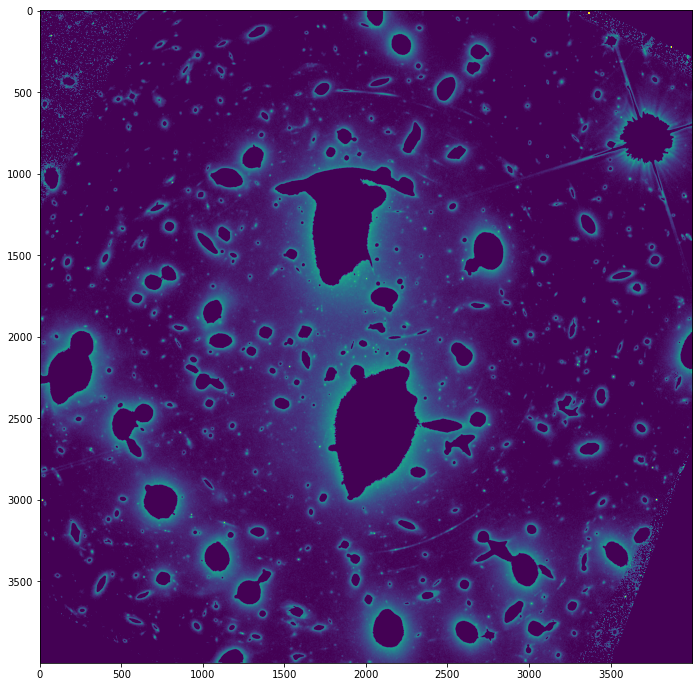

In [17]:
plot_segment_residual(segm_deblend, image)

In [18]:
segm_deblend.remove_border_labels(50)
len(segm_deblend.segments)

504

### Make Catalog

In [19]:
cat = source_properties(image, segm_deblend, wcs=wcs)

### Make Apertures

In [20]:
def plot_apertures(image, apertures, vmin=None, vmax=None):
    norm = ImageNormalize(stretch=SqrtStretch())
    plt.imshow(image, cmap='Greys_r', vmin=vmin, vmax=vmax)
    plt.title('Apertures')
    
    for aperture in apertures:
        aperture.plot(axes=plt.gca(), color='white', lw=1.5)

In [21]:
r = 3.  # approximate isophotal extent

apertures = []
for obj in cat:
    position = np.transpose((obj.xcentroid.value, obj.ycentroid.value))
    a = obj.semimajor_axis_sigma.value * r
    b = obj.semiminor_axis_sigma.value * r
    theta = obj.orientation.to(u.rad).value
    apertures.append(EllipticalAperture(position, a, b, theta=theta))

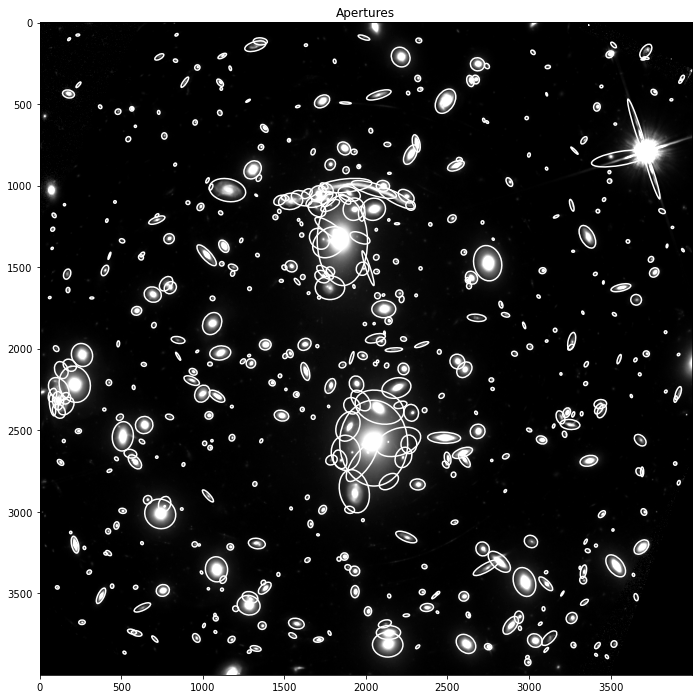

In [22]:
plot_apertures(image, apertures, vmin=0, vmax=mean_noise*300)

### Aperture Photometry

In [23]:
aperture_photometry_results = []
for aperture in apertures:
    aperture_photometry_results.append(aperture_photometry(image, aperture)['aperture_sum'][0])

# Save Catalog

In [24]:
table = cat.to_table()
table['aperture_sum'] = np.array(aperture_photometry_results)

In [25]:
table.write(output_path, format="ascii.csv", overwrite=True)